In [1]:
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = '&E}d~KiDvRmIUmZ>fd+h_TF*mg#:g~[<bPI<ix<E'
config = SHConfig()


if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
    

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
betsiboka_coords_wgs84 = [14.073486,45.893831,14.990845,46.305201]
resolution = 100
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 100 m resolution: (712, 453) pixels


[[1168.1216  1232.4174  1253.3552  ...  642.6871   674.3791   699.6838 ]
 [1177.3414  1224.295   1243.8103  ...  661.5752   678.566    694.9901 ]
 [1165.1482  1205.626   1226.0051  ...  671.30707  693.2532   697.43866]
 ...
 [1176.8226  1118.206   1103.25    ...  472.2779   487.48285  491.14294]
 [1180.2278  1154.5316  1148.8969  ...  482.59558  486.16837  491.1892 ]
 [1157.0754  1152.7498  1176.636   ...  491.8589   495.11414  495.7754 ]]


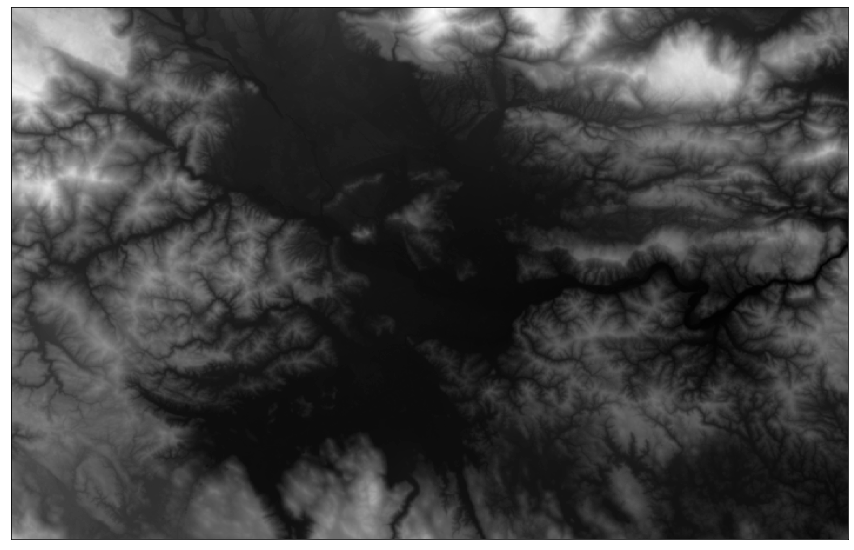

In [5]:
evalscript_dem = '''
//VERSION=3
function setup() {
  return {
    input: ["DEM"],

    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
'''

dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=('2020-06-12', '2020-06-13'),
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

dem_data = dem_request.get_data()
#print(dem_data)

# Plot DEM map
# vmin = 0; cutoff at sea level (0 m)
# vmax = 120; cutoff at high values (120 m)
print(dem_data[0])
#print(dem_data[1])
plot_image(dem_data[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=np.amin(dem_data[0]), vmax=np.amax(dem_data[0]))
data = dem_data[0];


In [6]:
 

new_data = list(map(lambda x: list(map(lambda y: (y,False),x)) ,data))

In [7]:
'''
def find_closest(data, x, y, amount_x, amount_y, amount_z):
    final_array = []
    
    curr_x = x + amount_x
    curr_y = y + amount_y
    curr_z = data[curr_x][curr_y] 
    print(curr_x, curr_y, curr_z)
    while True:
        if curr_x > len(data) or curr_y > len(data[0]):
            return None
        calculated_z = data[curr_x][curr_y]
        if abs(calculated_z - curr_z) < 1:
            return (curr_x, curr_y)
        else:
            curr_x += amount_x
            curr_y += amount_y
            curr_z += amount_z     
        
find_closest(test, x=0,y=0, amount_x=110, amount_y=20, amount_z=100)
'''

'\ndef find_closest(data, x, y, amount_x, amount_y, amount_z):\n    final_array = []\n    \n    curr_x = x + amount_x\n    curr_y = y + amount_y\n    curr_z = data[curr_x][curr_y] \n    print(curr_x, curr_y, curr_z)\n    while True:\n        if curr_x > len(data) or curr_y > len(data[0]):\n            return None\n        calculated_z = data[curr_x][curr_y]\n        if abs(calculated_z - curr_z) < 1:\n            return (curr_x, curr_y)\n        else:\n            curr_x += amount_x\n            curr_y += amount_y\n            curr_z += amount_z     \n        \nfind_closest(test, x=0,y=0, amount_x=110, amount_y=20, amount_z=100)\n'

In [8]:

sel_x = 155
sel_y = 200

test = [[0,0,1,0,2,0],
        [0,0.5,1.5,2,0,0],
        [0,3,4,4,5,2]]

test = np.array([np.array(list(range(20)) + list(range(18,-4,-2)))*(i/20) for i in range(30)]);

In [9]:
def closest_oglisce(T, shape):
    # T = (x,y)
    # za točko T najde najbližjo točko z znanim podatkom o višini
    T_new = (round(T[0]), round(T[1]))
    if T_new[0] == shape[0]:
        T_new = (T_new[0]-1, T_new[1])
    if T_new[0] == -1:
        T_new = (0, T_new[1])
    if T_new[1] == shape[1]:
        T_new = (T_new[0], T_new[1]-1)
    if T_new[1] == -1:
        T_new = (T_new[0], 0)
    return (int(T_new[0]), int(T_new[1]))

In [10]:
def build_ray_arree(data, x, y, amount_x, amount_y):
    final_array = []
    data = np.array(list(map(list, zip(*data))))
    ray_trace = []
    print(data[:2,:5])
    curr_x = x 
    curr_y = y
    while not (curr_x > len(data) or curr_y > len(data[0]) or curr_x < 0 or curr_y < 0):
        print(round(curr_x,2), round(curr_y,2))

        ray_trace.append((curr_x, curr_y))
        cl_x, cl_y = closest_oglisce((curr_x, curr_y), data.shape)
        final_array.append((data[cl_x][cl_y], (curr_x,curr_y)))
        curr_x += amount_x
        curr_y += amount_y
    
    print(ray_trace)
    return final_array, ray_trace

#print(test)
#r = build_ray_arree(test, x=0,y=0, amount_x=0.7, amount_y=0.1);
#print(r)




2326


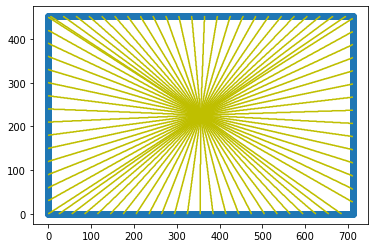

In [20]:
from bresenham import bresenham

import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# m vrstic (y), n stolpcev (x)
data = data#[:20,:15]
m, n = data.shape[0], data.shape[1]
edge_points = list(zip([0 for _ in range(m)], list(range(m)))) + list(zip([n-1 for _ in range(m)], list(range(m)))) + list(zip(list(range(1,n-1)), [0 for _ in range(n-2)])) + list(zip(list(range(1,n-1)), [m-1 for _ in range(n-1)]))

x,y = list(map(lambda x : x[0], edge_points)), list(map(lambda x : x[1], edge_points))
plt.plot(x,y,'o')

center_point = (n//2,m//2)
rays = []

for p in edge_points:
    temp_ray = list(bresenham(center_point[0], center_point[1], p[0], p[1]))
    # dodamo podatek o višini
    ray = OrderedDict()
    for t in temp_ray[1:-1]:
        ray[t] = (data[t[1],t[0]])
    rays.append(ray)

print(len(rays))
for i in range(0,len(rays),30):
    ray = rays[i].keys()
    x,y = list(map(lambda x : x[0], ray)), list(map(lambda x : x[1], ray))
    plt.plot(x,y,color='y')
#    print(ray)

#plt.set_aspect('equal')

    
plt.show()
#[(-1, -4), (0, -3), (0, -2), (1, -1), (2, 0), (2, 1), (3, 2)]

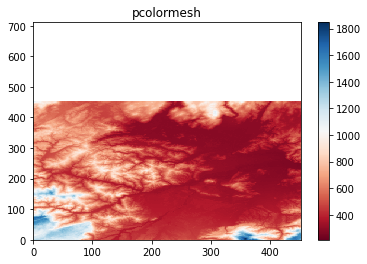

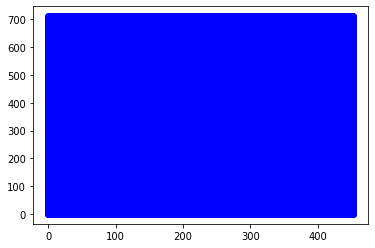

In [19]:
# Make data.
x = np.arange(data.shape[0])
y = np.arange(data.shape[1])
x,y = np.meshgrid(x,y)
z = data[x,y]
#print(z)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.min(z), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

####
mesh = plt.plot(x,y,'o',color='b')
plt.show()

In [13]:
z = np.array([100,70,30,20,60,80,90,100,120,40,20,145,170])


#is_left(np.array([0,100]),np.array([1,70]),np.array([2,30]))


2326


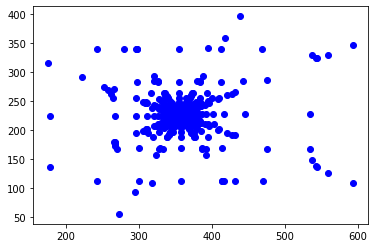

In [15]:
def is_left(p1, p2, p3):
    p1, p2, p3 = list(map(np.array, [p1, p2, p3]))
    #print(p1)
    return np.cross(p3 - p1, p2 - p1) < 0


def seeable_points_on_ray(ray):
    ray = list(ray)
    #print(list(ray))
    start = ray[0]
    middle = ray[1]
    
    final_ray = {}
    # prvo točko, ki ni naša, vedno vidimo
    final_ray[ray[0]] = 1
    
    for element in ray[1:]:
        if is_left(start,middle,element):
            middle = element
            final_ray[element] = 1
        else:
            final_ray[element] = 0
    
    return final_ray

print(len(rays))
seeable = {}
for ray in rays:
    see_ray = seeable_points_on_ray(ray.keys())
    for p in see_ray:
        if see_ray[p] == 1:
            plt.plot(p[0],p[1],'o', color='b')
plt.show()
        
#seeable_points(z)